In [1]:
import tensorflow as tf
import os
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
from tqdm import tqdm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
mnist = input_data.read_data_sets("./mnist/", one_hot=True)

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [3]:
print(mnist.train.num_examples)
print(mnist.validation.num_examples)
print(mnist.test.num_examples)
print(mnist.train.images[0].shape, max(mnist.train.images[0]), min(mnist.train.images[0]))
print(mnist.train.labels[0])

55000
5000
10000
(784,) 0.9960785 0.0
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [4]:
EPOCH = 40000
BATCH_SIZE = 128
LEARNING_RATE_BASE = 0.1
LEARNING_RATE_DECAY = 0.999
REGULARIZAER_RATE = 0.001
MOVING_AVREAGE_DECAY = 0.99

INPUT_NODE = 784
OUTPUT_NODE = 10
HIDDEN_LAYER_1_NODE = 500

In [5]:
def forward(input_tensor, weight1, bias1, weight2, bias2, avg_class):
    if not avg_class:
        a1 = tf.nn.relu(tf.matmul(input_tensor, weight1) + bias1)
        return tf.matmul(a1, weight2) + bias2
    else:
        a1 = tf.nn.relu(tf.matmul(input_tensor, avg_class.average(weight1)) + avg_class.average(bias1))
        return tf.matmul(a1, avg_class.average(weight2)) + avg_class.average(bias2)

In [6]:
def train(mnist):
    x = tf.placeholder(tf.float32, shape=[None, INPUT_NODE])
    y_ = tf.placeholder(tf.float32, shape=[None, OUTPUT_NODE])
    
    weight1 = tf.Variable(tf.truncated_normal(shape=[INPUT_NODE, HIDDEN_LAYER_1_NODE], stddev=0.1))
    bias1 = tf.Variable(tf.zeros(shape=[HIDDEN_LAYER_1_NODE]))
    weight2 = tf.Variable(tf.truncated_normal(shape=[HIDDEN_LAYER_1_NODE, OUTPUT_NODE], stddev=0.1))
    bias2 = tf.Variable(tf.zeros(shape=[OUTPUT_NODE]))
    
    y = forward(x, weight1, bias1, weight2, bias2, None)
    
    global_step = tf.Variable(0, trainable=False)
    ema = tf.train.ExponentialMovingAverage(MOVING_AVREAGE_DECAY, global_step)
    ema_op = ema.apply(tf.trainable_variables())
    y_avg = forward(x, weight1, bias1, weight2, bias2, ema)
    
    loss_cem = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZAER_RATE)
    loss_reg = regularizer(weight1) + regularizer(weight2)
    loss = loss_cem + loss_reg
    
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE, 
                                               global_step, 
                                               mnist.train.num_examples/BATCH_SIZE, 
                                               LEARNING_RATE_DECAY, 
                                               True)
    
    train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step)
    
    train_op = tf.group(train, ema_op)
    # with tf.control_dependencies([train, ema_op]):
    #     train_op = tf.no_op(name="train")
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32))
    accuracy_avg = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_avg, 1), tf.argmax(y_, 1)), tf.float32))
    
    val_acc_history, test_acc_history, weight_abs = [], [], []
    val_acc_history_avg, test_acc_history_avg = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in tqdm(range(EPOCH)):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            sess.run(train_op, feed_dict={x: xs, y_: ys})
            if i % 1000 == 0:
                val_accuracy = sess.run(accuracy, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
                test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                val_acc_history.append([i, val_accuracy])
                test_acc_history.append(test_accuracy)
                weight_abs.append(sess.run(tf.reduce_mean(tf.abs(weight1)) + tf.reduce_mean(tf.abs(weight2))))
                # print("After %d step(s), validation accuracy is %g" % (i, val_accuracy))
                
                val_accuracy_avg = sess.run(accuracy_avg, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
                test_accuracy_avg = sess.run(accuracy_avg, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                val_acc_history_avg.append([i, val_accuracy_avg])
                test_acc_history_avg.append(test_accuracy_avg)
                             
        test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        print("After %d train steps, test accuracy is %g" % (i, test_accuracy))
    
    ax1 = plt.subplot(111)
    l1, = ax1.plot([x[0] for x in val_acc_history], [x[1] for x in val_acc_history], "-", 
                   color="red", alpha=0.818)
    l2, = ax1.plot([x[0] for x in val_acc_history], test_acc_history, "-", color="blue", alpha=0.818)
    l3, = ax1.plot([x[0] for x in val_acc_history], [x[1] for x in val_acc_history_avg], 'kp-.', 
                   color="red", alpha=0.818)
    l4, = ax1.plot([x[0] for x in val_acc_history], test_acc_history_avg, 'kp-.', color="blue", alpha=0.818)
    ax1.set_ylim(0.95, 1)
    ax1.set_xlabel("steps")
    ax1.set_ylabel("accuracy")
    
    ax2 = ax1.twinx()
    l5, = ax2.plot([x[0] for x in val_acc_history], weight_abs, "-", color="pink", alpha=0.818)
    plt.legend(handles=[l1,l2,l3,l4,l5],
               labels=["validation accuracy", "test accuracy", "validation accuracy(ema)", "test accuracy(ema)", "weight abs"],
               # bbox_to_anchor=[0.98, 0.72],
               shadow = True,
               )
    plt.grid(alpha=0.4)
    plt.show()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [03:53<00:00, 170.95it/s]


After 39999 train steps, test accuracy is 0.9798


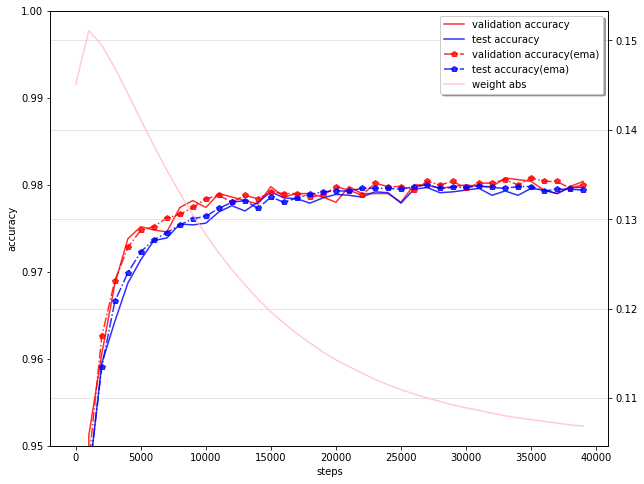

In [7]:
if __name__ == "__main__":
    train(mnist)